# Calibrating and saving kinematic age relations given an external sample of stellar ages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
import age_prediction_tool as lf

import corner

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10, 6]

# Stokholm RGB Sample

Read in data and calculate actions

In [8]:
# xmatch = Table.read('StokholmRGB_GaiaXmatch.csv')
# xmatch = xmatch[xmatch['parallax'] > 0]

# lf.calc_jz(xmatch, fname='StokholmRGB_GaiaXmatch_WithJz.fits')

xmatch = Table.read('StokholmRGB_GaiaXmatch_WithJz.fits')
xmatch = xmatch[np.log(xmatch['Jz']) < 20]

In [9]:
age_nomask = np.array(xmatch['AGE_BASTA'])/1000
Jz_nomask = np.array(xmatch['Jz'])
age_err_nomask = np.array(np.nanmean((xmatch['LOWER_ERROR_AGE_BASTA']/1000, xmatch['UPPER_ERROR_AGE_BASTA']/1000), axis=0))

mask = age_err_nomask > 0

age = np.array(age_nomask[mask])
lnJz = np.array(np.log(Jz_nomask[mask]))
age_err = np.array(age_err_nomask[mask])

assert np.all(np.isfinite(age_err))
assert np.all(age_err > 0)

Text(0, 0.5, 'Age (Gyr)')

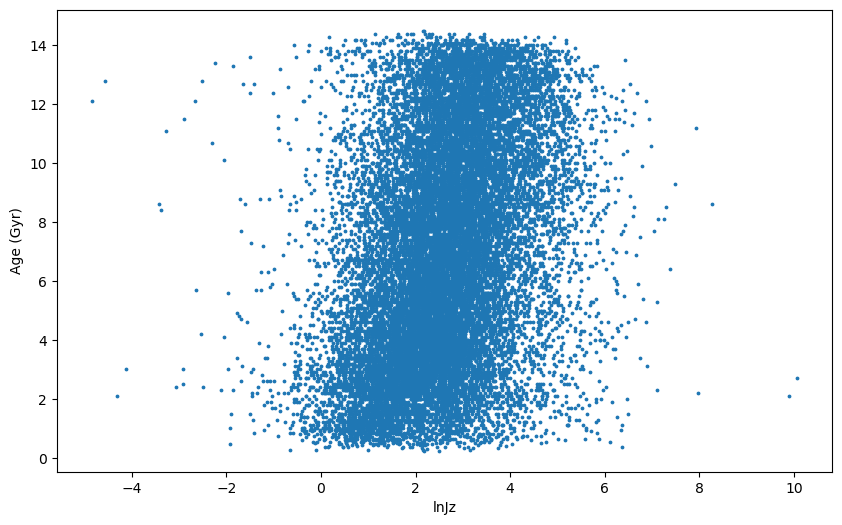

In [10]:
plt.scatter(lnJz,age, s=3)

plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

Calibrate monotonic spline model

In [11]:
spline = lf.KinematicAgeSpline(lnJz, age, age_err)
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

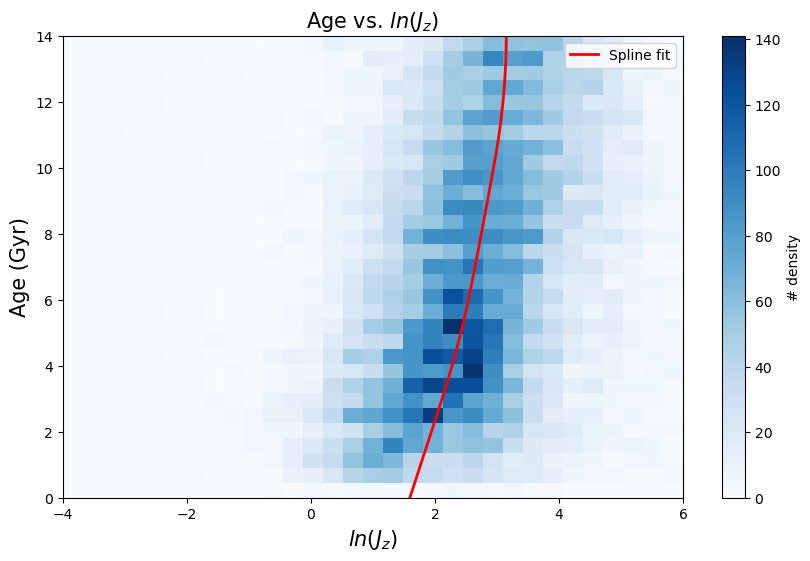

In [12]:
spline.plot_fit()

In [22]:
spline.write(directory='RGB_spline_model/')

In [23]:
newspline = lf.read(directory='RGB_spline_model/')

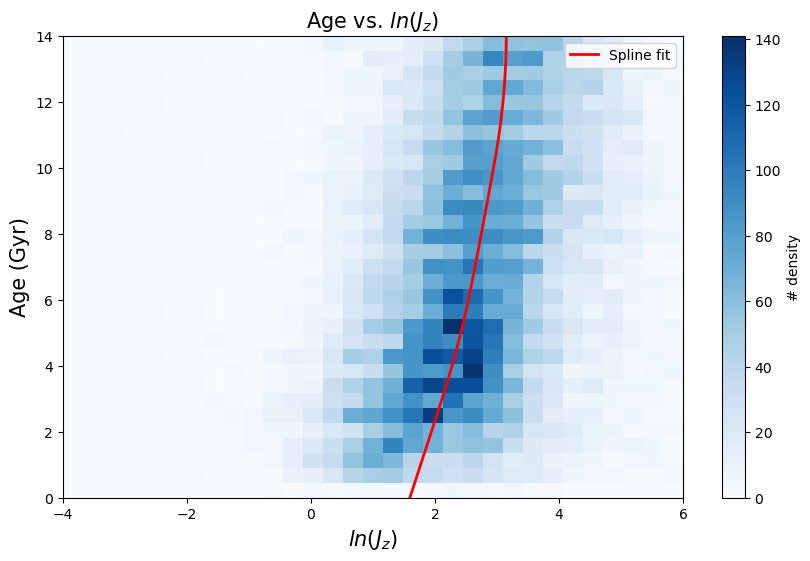

In [24]:
newspline.plot_fit()

In [25]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

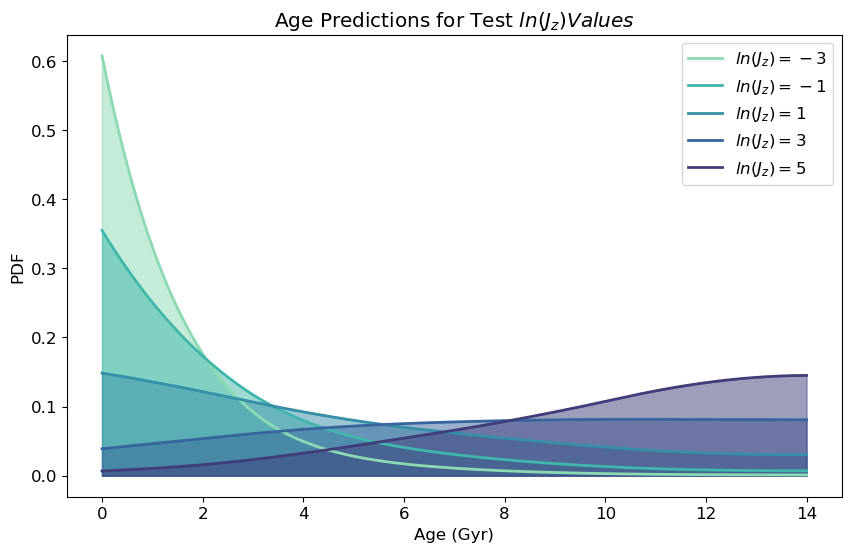

In [27]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')

In [28]:
kepler_ages = Table.read('Kepler_Age_Predictions.fits')
kep42 = float(np.log(kepler_ages[kepler_ages['kepid'] == 8561063]['Jz']))
kep125 = float(np.log(kepler_ages[kepler_ages['kepid'] == 10489206]['Jz']))
kep186 = float(np.log(kepler_ages[kepler_ages['kepid'] == 8120608]['Jz']))
kep249 = float(np.log(kepler_ages[kepler_ages['kepid'] == 7907423]['Jz']))
kep236 = float(np.log(kepler_ages[kepler_ages['kepid'] == 4725681]['Jz']))

/var/folders/fw/4y8lcb2j7b19v6vfzm__2nf80000gn/T/ipykernel_57164/3004247323.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kep42 = float(np.log(kepler_ages[kepler_ages['kepid'] == 8561063]['Jz']))
/var/folders/fw/4y8lcb2j7b19v6vfzm__2nf80000gn/T/ipykernel_57164/3004247323.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kep125 = float(np.log(kepler_ages[kepler_ages['kepid'] == 10489206]['Jz']))
/var/folders/fw/4y8lcb2j7b19v6vfzm__2nf80000gn/T/ipykernel_57164/3004247323.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your ar

In [29]:
# kep42 = 3.6486240894109683
# kep125 = -0.9615162137394352
# kep186 = -1.657133801967237
# kep249 = 0.9103696829926338
# kep236 = -0.39834222813493686

Text(0.5, 1.0, 'Age Predictions for M Dwarf Planet Hosts')

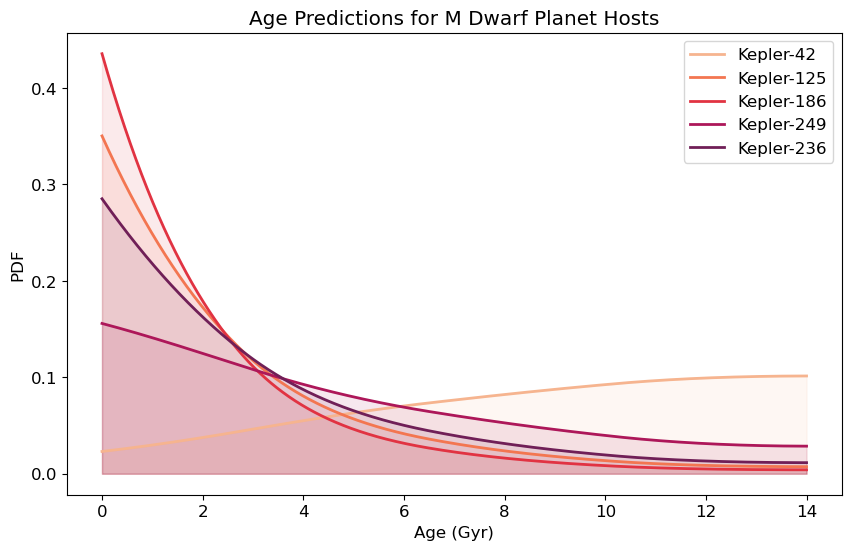

In [31]:
eval_grid, eval_pdf_kep42 = spline.evaluate_ages(kep42)
_, eval_pdf_kep125 = spline.evaluate_ages(kep125)
_, eval_pdf_kep186 = spline.evaluate_ages(kep186)
_, eval_pdf_kep249 = spline.evaluate_ages(kep249)
_, eval_pdf_kep236 = spline.evaluate_ages(kep236)


import seaborn as sns

plt.plot(eval_grid, eval_pdf_kep42, label='Kepler-42', color=sns.color_palette("rocket_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep125, label='Kepler-125', color=sns.color_palette("rocket_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep186, label='Kepler-186', color=sns.color_palette("rocket_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep249, label='Kepler-249', color=sns.color_palette("rocket_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep236, label='Kepler-236', color=sns.color_palette("rocket_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_kep42, 0, color=sns.color_palette("rocket_r").as_hex()[0], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep125, 0, color=sns.color_palette("rocket_r").as_hex()[1], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep186, 0, color=sns.color_palette("rocket_r").as_hex()[2], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep249, 0, color=sns.color_palette("rocket_r").as_hex()[3], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep236, 0, color=sns.color_palette("rocket_r").as_hex()[4], alpha=0.1)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for M Dwarf Planet Hosts')

# StarHorse APOGEE Sample

Read in data and calculate actions

In [32]:
# starhorse_apogee = Table.read('../starhorse_data/StarHorse_APOGEE_composite.ecsv')
# starhorse_apogee = starhorse_apogee[starhorse_apogee['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']
# starhorse_apogee = starhorse_apogee[starhorse_apogee['parallax'] > 0]

# calc_jz(starhorse_apogee, fname='StarHorse_APOGEE_composite_WithActions.fits')

xmatch = Table.read('../starhorse_data/apogee_comp_withjz.ecsv')
xmatch = xmatch[xmatch['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']
xmatch = xmatch[np.log(xmatch['Jz']) < 20]

In [33]:
age_nomask = np.array(xmatch['age50'])
Jz_nomask = np.array(xmatch['Jz'])
age_err_nomask = np.array(np.nanmean((xmatch['age50']-xmatch['age16'], xmatch['age84']-xmatch['age50']), axis=0))

mask = age_err_nomask > 0

age = np.array(age_nomask[mask])
lnJz = np.array(np.log(Jz_nomask[mask]))
age_err = np.array(age_err_nomask[mask])

assert np.all(np.isfinite(age_err))
assert np.all(age_err > 0)

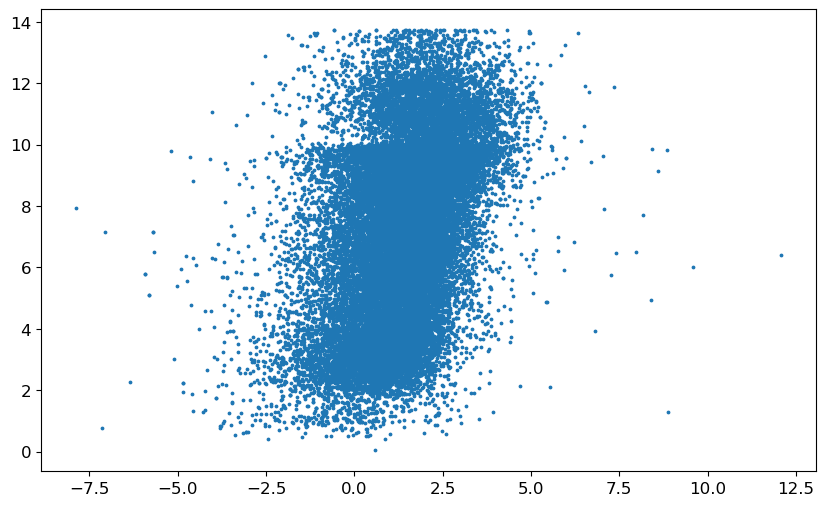

In [34]:
plt.scatter(lnJz, age, s=3)

Calibrate monotonic spline model

In [35]:
spline = lf.KinematicAgeSpline(lnJz, age, age_err)
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
spline.plot_fit()

In [36]:
spline.write(directory='MSTO_spline_model/')

In [37]:
newspline = lf.read(directory='MSTO_spline_model/')

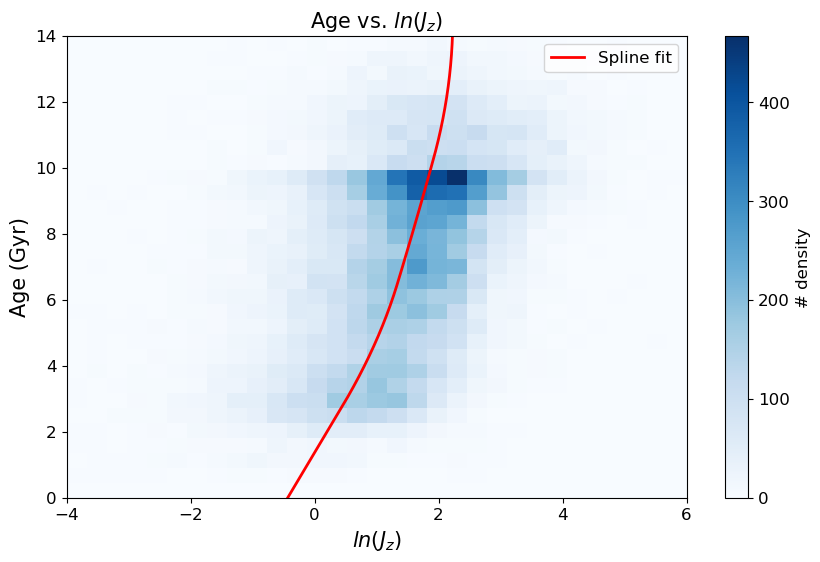

In [38]:
newspline.plot_fit()

In [ ]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

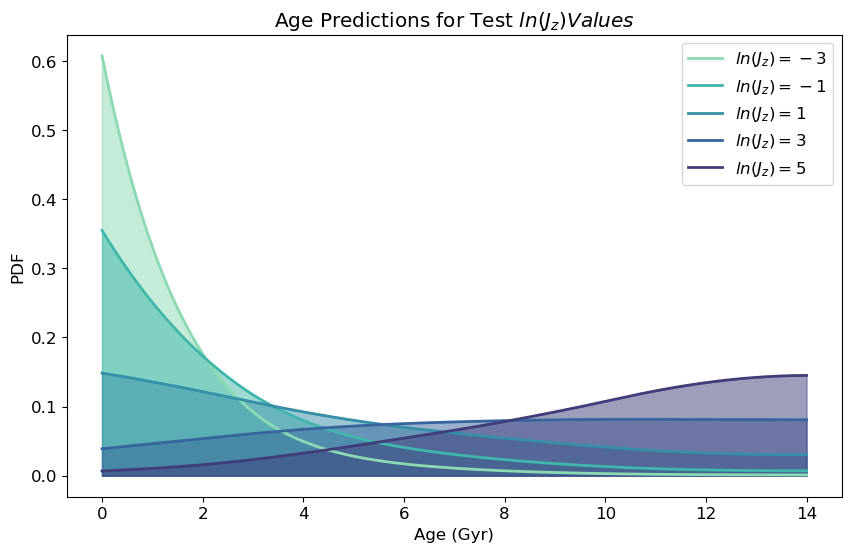

In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')